In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('../data/exams.csv')

# Encode categorical variables
label_encoders = {}
for column in ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Upsample underrepresented ethnic groups
grouped_data = data.groupby('race/ethnicity')
max_size = grouped_data.size().max()

# Apply upsampling
upsampled_data = grouped_data.apply(lambda x: x.sample(max_size, replace=True) if len(x) < max_size else x)
upsampled_data = upsampled_data.reset_index(drop=True)

# Define features and target with the upsampled data
X_upsampled = upsampled_data.drop(columns=['math score', 'reading score', 'writing score'])
y_upsampled = upsampled_data[['math score', 'reading score', 'writing score']].values

# Normalize the features
scaler_X = StandardScaler()
X_upsampled = scaler_X.fit_transform(X_upsampled)

# Normalize the target variables
scaler_y = StandardScaler()
y_upsampled = scaler_y.fit_transform(y_upsampled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=42)

# Convert X_test back to a DataFrame to see the distribution
X_test_df = pd.DataFrame(scaler_X.inverse_transform(X_test), columns=upsampled_data.drop(columns=['math score', 'reading score', 'writing score']).columns)

# Add the ethnicity back to see the group sizes in the test set
X_test_df['race/ethnicity'] = X_test_df['race/ethnicity'].round().astype(int)
X_test_df['race/ethnicity'] = label_encoders['race/ethnicity'].inverse_transform(X_test_df['race/ethnicity'])

# Print the size of each group in the test data
print("Group sizes in the test data:")
print(X_test_df['race/ethnicity'].value_counts())

# Convert to tensors
X_tensor_upsampled = torch.tensor(X_upsampled, dtype=torch.float32)
y_tensor_upsampled = torch.tensor(y_upsampled, dtype=torch.float32)

# Combine into a dataset
dataset_upsampled = TensorDataset(X_tensor_upsampled, y_tensor_upsampled)

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Dropout rate to 20%

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the neural network, loss function, and optimizer
input_size = X_upsampled.shape[1]
output_size = y_upsampled.shape[1]
model = NeuralNet(input_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Set the number of epochs
num_epochs = 30

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor_upsampled)):
    print(f'Fold {fold + 1}')
    batch_size = 32
    # Create data loaders
    train_loader = DataLoader(dataset=TensorDataset(X_tensor_upsampled[train_idx], y_tensor_upsampled[train_idx]), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=TensorDataset(X_tensor_upsampled[val_idx], y_tensor_upsampled[val_idx]), batch_size=batch_size, shuffle=False)
    
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        
        # Adjust learning rate
        scheduler.step(val_loss)
    
    # Print the validation loss for this fold
    print(f'Validation Loss for Fold {fold + 1}: {val_loss}')

/var/folders/rd/61q0tgy52hn29lz2xfggbcnw0000gn/T/ipykernel_68687/1398983858.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  upsampled_data = grouped_data.apply(lambda x: x.sample(max_size, replace=True) if len(x) < max_size else x)


Group sizes in the test data:
race/ethnicity
group B    78
group A    67
group D    64
group E    61
group C    53
Name: count, dtype: int64
Fold 1
Validation Loss for Fold 1: 0.6329036869786002
Fold 2
Validation Loss for Fold 2: 0.7764909782192924
Fold 3
Validation Loss for Fold 3: 0.6248158379034563
Fold 4
Validation Loss for Fold 4: 0.5700735233046792
Fold 5
Validation Loss for Fold 5: 0.6478491886095568


In [3]:
# Group data by gender
males = upsampled_data[upsampled_data['gender'] == label_encoders['gender'].transform(['male'])[0]]
females = upsampled_data[upsampled_data['gender'] == label_encoders['gender'].transform(['female'])[0]]

# Get predictions for males and females
X_males = torch.tensor(scaler_X.transform(males.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
y_males_pred = model(X_males).detach().numpy()

X_females = torch.tensor(scaler_X.transform(females.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
y_females_pred = model(X_females).detach().numpy()

# Reverse normalization on predictions
y_males_pred_original = scaler_y.inverse_transform(y_males_pred)
y_females_pred_original = scaler_y.inverse_transform(y_females_pred)

# Calculate residuals (difference between actual and predicted scores)
residuals_males = males[['math score', 'reading score', 'writing score']].values - y_males_pred_original
residuals_females = females[['math score', 'reading score', 'writing score']].values - y_females_pred_original

# Create DataFrame for plotting gender analysis
gender_plot_data = pd.DataFrame({
    'gender': ['male'] * len(y_males_pred) + ['female'] * len(y_females_pred),
    'predicted_math_score': list(y_males_pred_original[:, 0]) + list(y_females_pred_original[:, 0]),
    'predicted_reading_score': list(y_males_pred_original[:, 1]) + list(y_females_pred_original[:, 1]),
    'predicted_writing_score': list(y_males_pred_original[:, 2]) + list(y_females_pred_original[:, 2]),
    'residual_math_score': list(residuals_males[:, 0]) + list(residuals_females[:, 0]),
    'residual_reading_score': list(residuals_males[:, 1]) + list(residuals_females[:, 1]),
    'residual_writing_score': list(residuals_males[:, 2]) + list(residuals_females[:, 2])
})

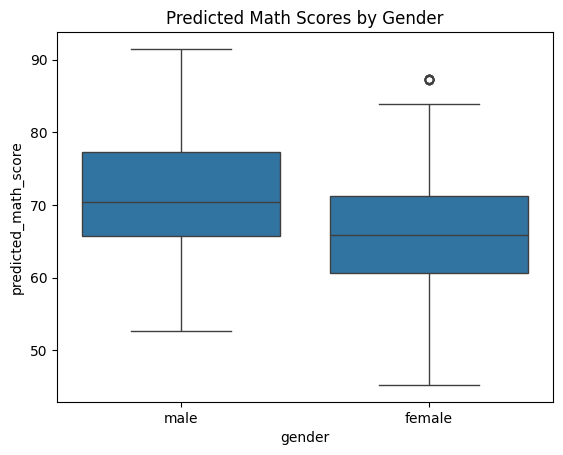

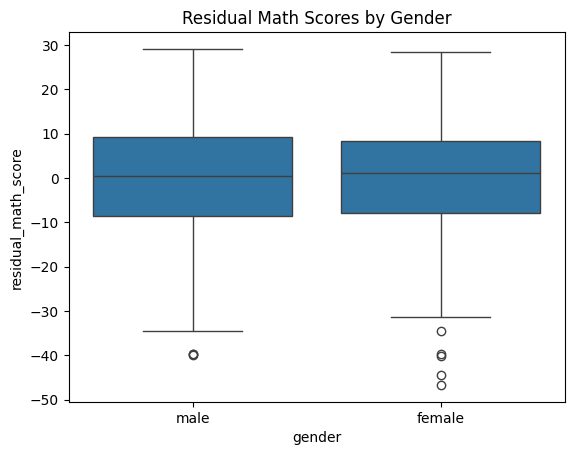

In [4]:
# Plot predicted scores by gender
# Plot residuals by gender
sns.boxplot(x='gender', y='predicted_math_score', data=gender_plot_data)
plt.title('Predicted Math Scores by Gender')
plt.show()

sns.boxplot(x='gender', y='residual_math_score', data=gender_plot_data)
plt.title('Residual Math Scores by Gender')
plt.show()

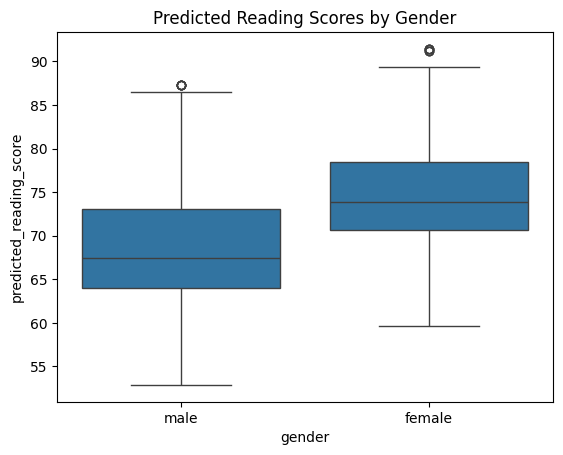

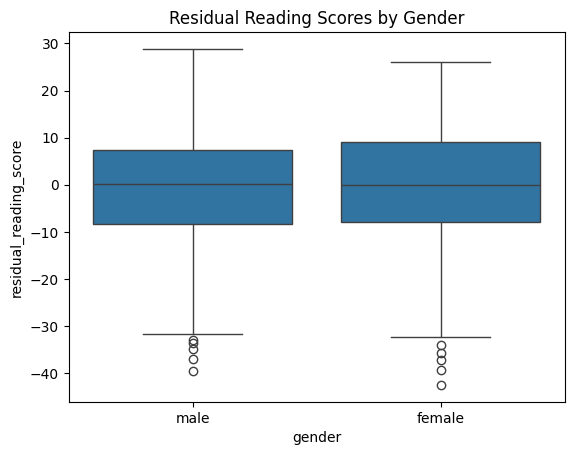

In [5]:
sns.boxplot(x='gender', y='predicted_reading_score', data=gender_plot_data)
plt.title('Predicted Reading Scores by Gender')
plt.show()

sns.boxplot(x='gender', y='residual_reading_score', data=gender_plot_data)
plt.title('Residual Reading Scores by Gender')
plt.show()

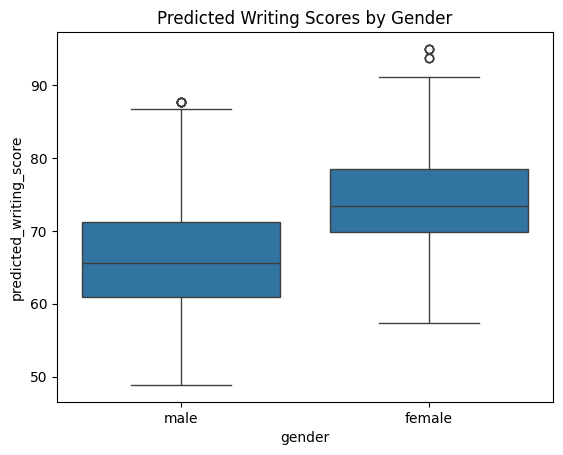

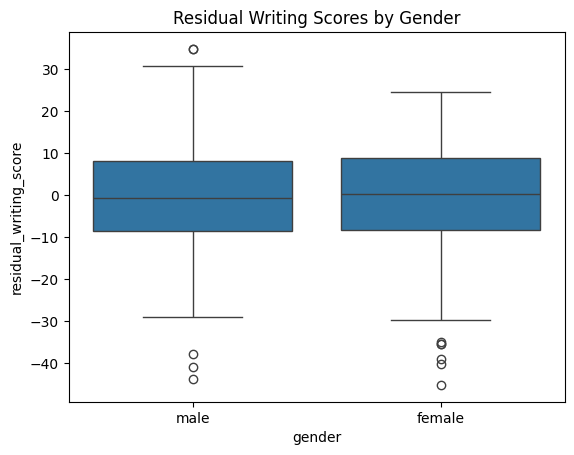

In [6]:
sns.boxplot(x='gender', y='predicted_writing_score', data=gender_plot_data)
plt.title('Predicted Writing Scores by Gender')
plt.show()

sns.boxplot(x='gender', y='residual_writing_score', data=gender_plot_data)
plt.title('Residual Writing Scores by Gender')
plt.show()

In [10]:
# Group data by ethnicity
ethnicities = upsampled_data['race/ethnicity'].unique()

# Initialize lists to store the data for ethnicity plotting
predicted_math_scores = []
predicted_reading_scores = []
predicted_writing_scores = []
residual_math_scores = []
residual_reading_scores = []
residual_writing_scores = []
ethnicity_labels = []

# Loop over each ethnicity group and make predictions
for ethnicity in ethnicities:
    group_data = upsampled_data[upsampled_data['race/ethnicity'] == ethnicity]
    
    X_group = torch.tensor(scaler_X.transform(group_data.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
    y_group_actual = group_data[['math score', 'reading score', 'writing score']].values
    
    # Predict the scores
    y_group_pred = model(X_group).detach().numpy()
    
    # Reverse normalization on predictions
    y_group_pred_original = scaler_y.inverse_transform(y_group_pred)
    
    # Calculate residuals
    residuals = y_group_actual - y_group_pred_original
    
    # Store the results for plotting
    predicted_math_scores.extend(y_group_pred_original[:, 0])
    predicted_reading_scores.extend(y_group_pred_original[:, 1])
    predicted_writing_scores.extend(y_group_pred_original[:, 2])
    residual_math_scores.extend(residuals[:, 0])
    residual_reading_scores.extend(residuals[:, 1])
    residual_writing_scores.extend(residuals[:, 2])
    ethnicity_labels.extend([ethnicity] * len(y_group_pred_original))

# Create DataFrame for plotting ethnicity analysis
ethnicity_plot_data = pd.DataFrame({
    'predicted_math_score': predicted_math_scores,
    'predicted_reading_score': predicted_reading_scores,
    'predicted_writing_score': predicted_writing_scores,
    'residual_math_score': residual_math_scores,
    'residual_reading_score': residual_reading_scores,
    'residual_writing_score': residual_writing_scores,
    'race/ethnicity': ethnicity_labels
})

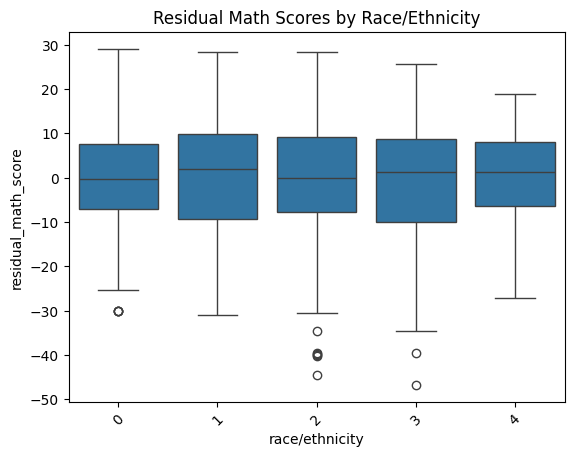

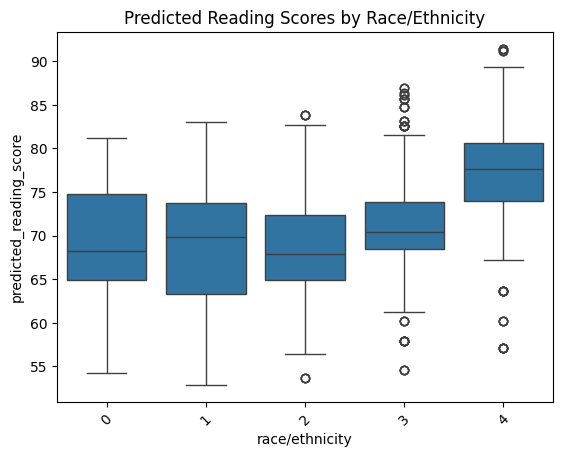

In [13]:
# Plot residual math scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='residual_math_score', data=ethnicity_plot_data)
plt.title('Residual Math Scores by Race/Ethnicity')
plt.xticks(rotation=45)
plt.show()

# Plot predicted reading scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='predicted_reading_score', data=ethnicity_plot_data)
plt.title('Predicted Reading Scores by Race/Ethnicity')
plt.xticks(rotation=45)
plt.show()

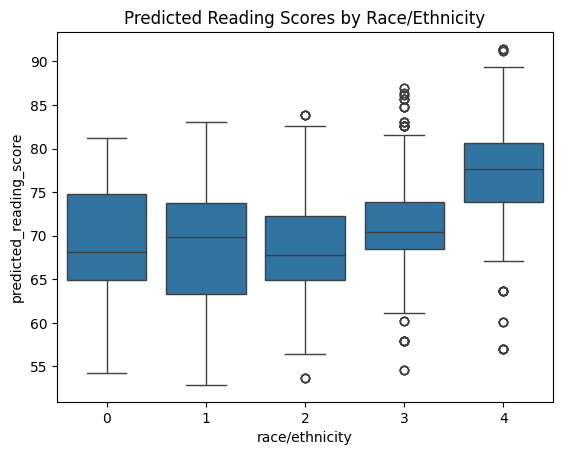

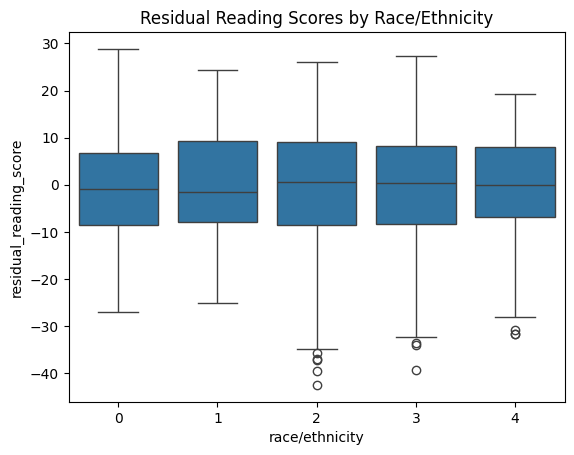

In [11]:
# Plot predicted reading scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='predicted_reading_score', data=ethnicity_plot_data)
plt.title('Predicted Reading Scores by Race/Ethnicity')
plt.show()

# Plot residual reading scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='residual_reading_score', data=ethnicity_plot_data)
plt.title('Residual Reading Scores by Race/Ethnicity')
plt.show()

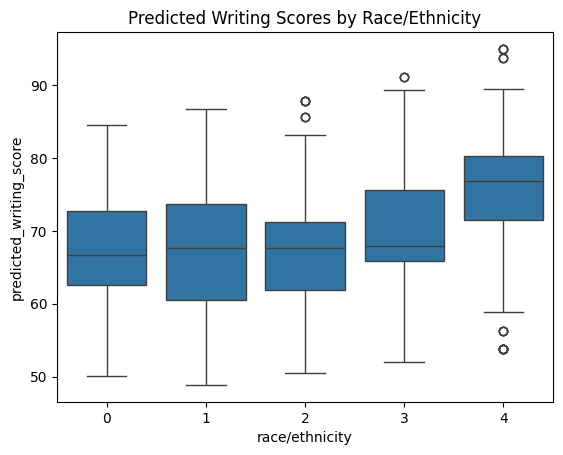

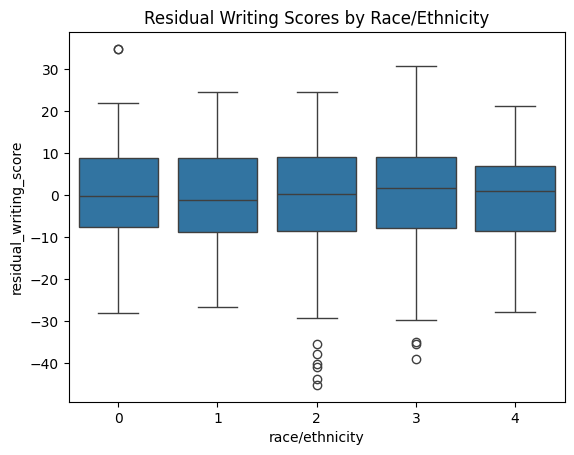

In [12]:
# Plot predicted writing scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='predicted_writing_score', data=ethnicity_plot_data)
plt.title('Predicted Writing Scores by Race/Ethnicity')
plt.show()

# Plot residual writing scores by race/ethnicity
sns.boxplot(x='race/ethnicity', y='residual_writing_score', data=ethnicity_plot_data)
plt.title('Residual Writing Scores by Race/Ethnicity')
plt.show()

In [14]:
# Group data by parental level of education
education_levels = upsampled_data['parental level of education'].unique()

# Initialize lists to store the data for parental level of education plotting
predicted_math_scores = []
predicted_reading_scores = []
predicted_writing_scores = []
residual_math_scores = []
residual_reading_scores = []
residual_writing_scores = []
education_labels = []

# Loop over each parental education level group and make predictions
for education in education_levels:
    group_data = upsampled_data[upsampled_data['parental level of education'] == education]
    
    X_group = torch.tensor(scaler_X.transform(group_data.drop(columns=['math score', 'reading score', 'writing score'])), dtype=torch.float32)
    y_group_actual = group_data[['math score', 'reading score', 'writing score']].values
    
    # Predict the scores
    y_group_pred = model(X_group).detach().numpy()
    
    # Reverse normalization on predictions
    y_group_pred_original = scaler_y.inverse_transform(y_group_pred)
    
    # Calculate residuals
    residuals = y_group_actual - y_group_pred_original
    
    # Store the results for plotting
    predicted_math_scores.extend(y_group_pred_original[:, 0])
    predicted_reading_scores.extend(y_group_pred_original[:, 1])
    predicted_writing_scores.extend(y_group_pred_original[:, 2])
    residual_math_scores.extend(residuals[:, 0])
    residual_reading_scores.extend(residuals[:, 1])
    residual_writing_scores.extend(residuals[:, 2])
    education_labels.extend([education] * len(y_group_pred_original))

# Create DataFrame for plotting parental level of education analysis
education_plot_data = pd.DataFrame({
    'predicted_math_score': predicted_math_scores,
    'predicted_reading_score': predicted_reading_scores,
    'predicted_writing_score': predicted_writing_scores,
    'residual_math_score': residual_math_scores,
    'residual_reading_score': residual_reading_scores,
    'residual_writing_score': residual_writing_scores,
    'parental level of education': education_labels
})

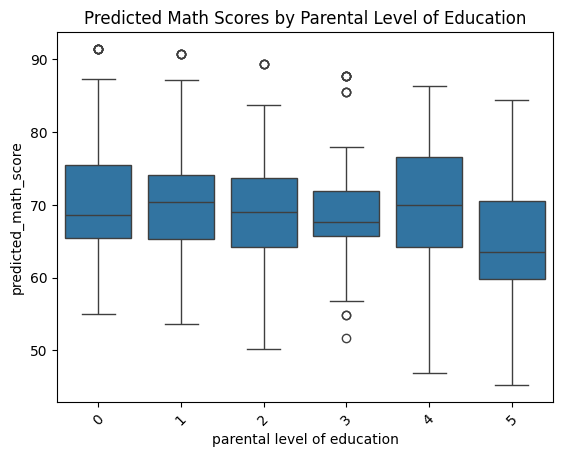

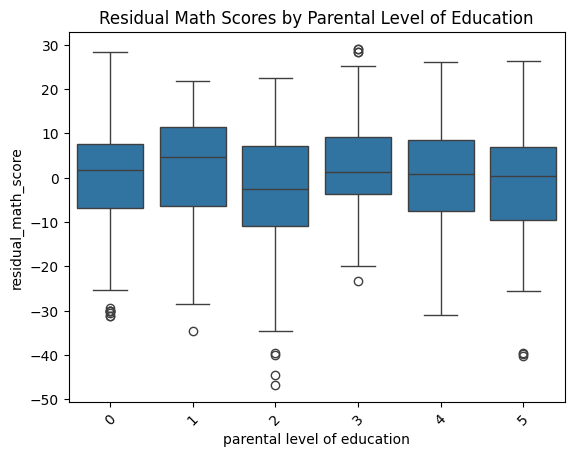

In [15]:

# Plot predicted math scores by parental level of education
sns.boxplot(x='parental level of education', y='predicted_math_score', data=education_plot_data)
plt.title('Predicted Math Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()

# Plot residual math scores by parental level of education
sns.boxplot(x='parental level of education', y='residual_math_score', data=education_plot_data)
plt.title('Residual Math Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()

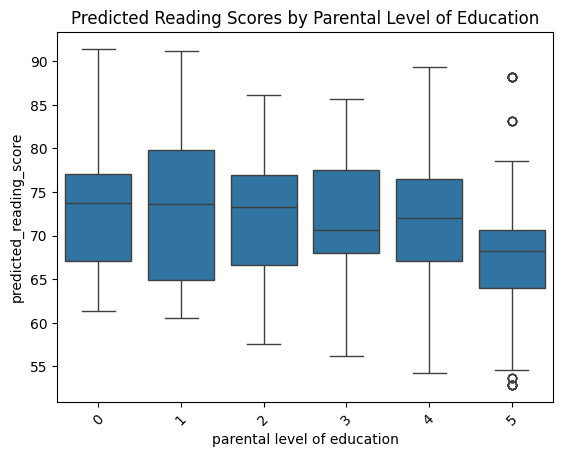

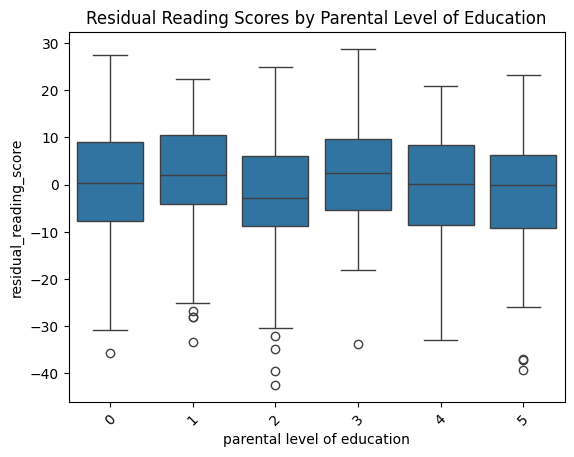

In [16]:
# Plot predicted reading scores by parental level of education
sns.boxplot(x='parental level of education', y='predicted_reading_score', data=education_plot_data)
plt.title('Predicted Reading Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()

# Plot residual reading scores by parental level of education
sns.boxplot(x='parental level of education', y='residual_reading_score', data=education_plot_data)
plt.title('Residual Reading Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()


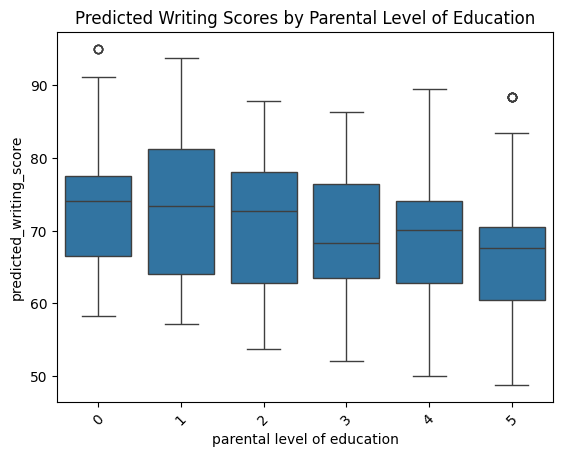

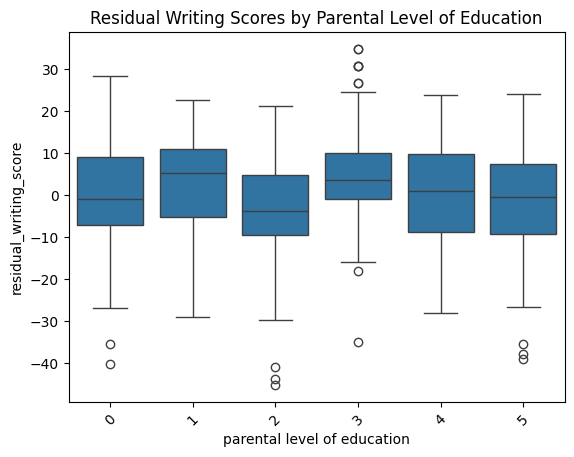

In [17]:
# Plot predicted writing scores by parental level of education
sns.boxplot(x='parental level of education', y='predicted_writing_score', data=education_plot_data)
plt.title('Predicted Writing Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()

# Plot residual writing scores by parental level of education
sns.boxplot(x='parental level of education', y='residual_writing_score', data=education_plot_data)
plt.title('Residual Writing Scores by Parental Level of Education')
plt.xticks(rotation=45)
plt.show()